# Applied Data Science Capstone
This notebook is for the IBM data science Capstone project.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import requests
import numpy as np
# import k-means from clustering stage
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
import json

import folium # map rendering library #!pip install folium
%matplotlib inline

# Data preprocessing

In [2]:
# Data in toronto
source = requests.get\
    (\
    'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=862527922'\
    ).text
# Extracted Data from Wiki
postal_code=BeautifulSoup(source,'lxml')
df=pd.read_html(str(postal_code.table))[0][1:]
df.columns=['Postal Code', 'Borough','Neighborhood']

# Only process the cells that have an assigned borough.
idx=df[df['Borough']=="Not assigned"].index
df.drop(idx, axis=0, inplace=True)

# More than one neighborhood can exist in one postal code area - Combine into one column
tor=df.groupby(['Postal Code', 'Borough'], sort = False).agg( ', '.join).reset_index()

# Importing lat/lon 
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data')

# Merge two datasets
df_toronto = pd.merge(tor, lat_lon, on = 'Postal Code')
df_toronto=df_toronto.drop(['Postal Code'],axis=1)

df_toronto['City'] = 'Toronto';
# Quickly examine df
df_toronto.head(2)

Borough      Neighborhood   Latitude  Longitude     City
0  North York         Parkwoods  43.753259 -79.329656  Toronto
1  North York  Victoria Village  43.725882 -79.315572  Toronto

In [3]:
df_toronto.shape

(103, 5)

In [4]:
# Data in New York
with open('/Users/xiaoxiny/Downloads/newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
ny_neighborhoods = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_newyork = pd.DataFrame(columns=column_names)

# loop through the data and fill the dataframe
for data in ny_neighborhoods:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_newyork = df_newyork.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

df_newyork['City'] = 'New York';
# Quickly examine df
df_newyork.head(2)

Borough Neighborhood   Latitude  Longitude      City
0   Bronx    Wakefield  40.894705 -73.847201  New York
1   Bronx   Co-op City  40.874294 -73.829939  New York

In [5]:
df_newyork.shape

(306, 5)

In [13]:
VERSION = '20180605' # Foursquare API version

# Function #1: to get nearbyy venues 
# Function #2: group venues and get frequency
# Function #3: top venues in region
def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, lat, lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def groupVenues(df_city): 
    # one hot encoding
    city_onehot = pd.get_dummies(df_city[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    city_onehot['Neighborhood'] = df_city['Neighborhood'] 

    # move neighborhood column to the first column
    fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
    city_onehot = city_onehot[fixed_columns]

    city_grouped = city_onehot.groupby('Neighborhood').mean().reset_index()
    return city_grouped

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [14]:
# Pipeline the four functions above
def return_full_grouped_sorted_df(df_input):
    df_cityVenues = getNearbyVenues(names=df_input['Neighborhood'],
                                       latitudes=df_newyork['Latitude'],
                                       longitudes=df_newyork['Longitude']
                                      )
    df_groupVenues= groupVenues(df_cityVenues)

    num_top_venues = 10
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    df_VenuesSorted = pd.DataFrame(columns=columns)
    df_VenuesSorted['Neighborhood'] = df_groupVenues['Neighborhood']

    for ind in np.arange(df_groupVenues.shape[0]):
        df_VenuesSorted.iloc[ind, 1:] = return_most_common_venues(df_groupVenues.iloc[ind, :], num_top_venues)

    return df_cityVenues,df_groupVenues,df_VenuesSorted

In [15]:
tor_cityVenues,tor_groupVenues,tor_VenuesSorted = return_full_grouped_sorted_df(df_toronto)
nyc_cityVenues,nyc_groupVenues,nyc_VenuesSorted = return_full_grouped_sorted_df(df_newyork)

In [33]:
tor_cityVenues.head(2)

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Parkwoods              40.894705              -73.847201   
1    Parkwoods              40.894705              -73.847201   

              Venue  Venue Latitude  Venue Longitude Venue Category  
0  Lollipops Gelato       40.894123       -73.845892   Dessert Shop  
1          Rite Aid       40.896649       -73.844846       Pharmacy

In [16]:
# Initial data disovery - What are the most popular venues in NYC & Toronto
nyc_top_vc = nyc_cityVenues['Venue Category'].value_counts(normalize=True).\
                rename_axis('Venue Category').reset_index(name='Frequency')
nyc_top_vc['Frequency %'] = nyc_top_vc['Frequency']*100;nyc_top_vc['City'] = 'New York';

tor_top_vc = tor_cityVenues['Venue Category'].value_counts(normalize=True).\
                rename_axis('Venue Category').reset_index(name='Frequency')
tor_top_vc['Frequency %'] = tor_top_vc['Frequency']*100;tor_top_vc['City'] = 'Toronto'

#Select the top 20 venues in NYC & Tor
num_of_interest=20
top_vc = nyc_top_vc.head(num_of_interest).append(tor_top_vc.head(num_of_interest))

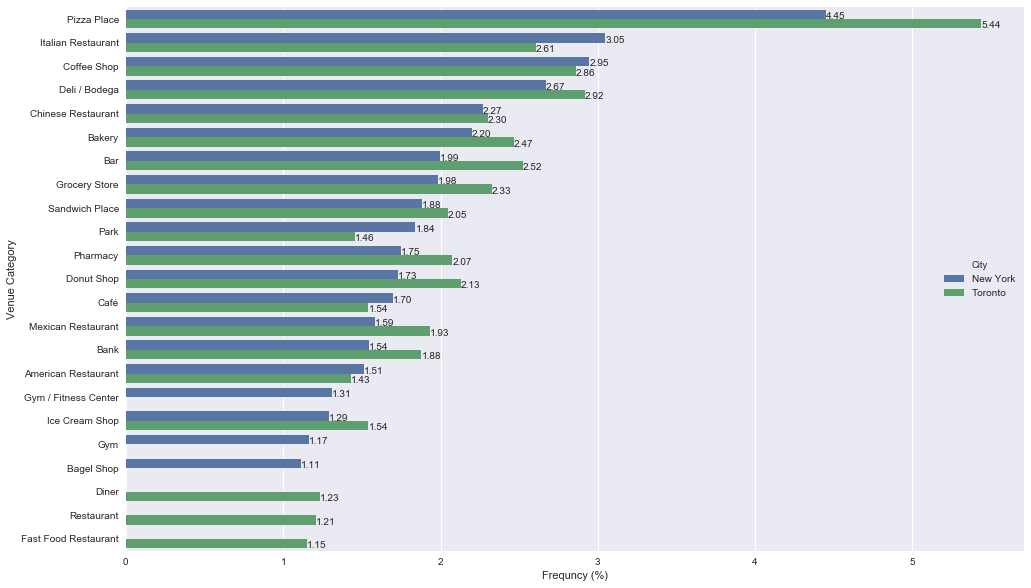

In [17]:
ax=plt.figure(figsize=(10*1.61,10))
ax = sns.barplot(x="Frequency %", y="Venue Category", hue="City", data=top_vc)
ax.set_xlabel('Frequncy (%)')

for p in ax.patches:
        percentage = '{:.2f}'.format(p.get_width())
        x = p.get_x() + p.get_width()+1.2*1e-4
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y))

## k-means

In [18]:
#prepare data
nyc_tor = nyc_groupVenues.append(tor_groupVenues)
nyc_tor_grouped_clustering = nyc_tor.drop('Neighborhood', 1).dropna(axis='columns') #.drop('Unnamed: 0', 1)

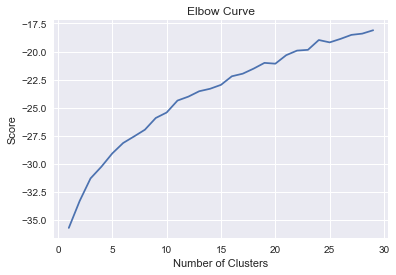

In [19]:
num_clusters = range(1, 30)

kmeans = [KMeans(n_clusters=i) for i in num_clusters]
score = [kmeans[i].fit(nyc_tor_grouped_clustering).score(nyc_tor_grouped_clustering) for i in range(len(kmeans))]

plt.plot(num_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')

plt.show()

In [20]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 0, 4, 4, 3, 3, 3, 3, 0], dtype=int32)

In [23]:
# add clustering labels
nyc_tor_VenuesSorted = nyc_VenuesSorted.append(tor_VenuesSorted)
nyc_tor_VenuesSorted.insert(0, 'Cluster Labels', kmeans.labels_)

data_merged = df_newyork.append(df_toronto)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood \ #.drop('Unnamed: 0', 1)\
data_merged = data_merged.join(nyc_tor_VenuesSorted.set_index('Neighborhood'), on='Neighborhood').dropna()

data_merged.head() # check the last columns!

Borough Neighborhood   Latitude  Longitude      City  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201  New York             0.0   
1   Bronx   Co-op City  40.874294 -73.829939  New York             0.0   
2   Bronx  Eastchester  40.887556 -73.827806  New York             0.0   
3   Bronx    Fieldston  40.895437 -73.905643  New York             3.0   
4   Bronx    Riverdale  40.890834 -73.912585  New York             3.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0              Pharmacy           Pizza Place        Ice Cream Shop   
1    Chinese Restaurant  Fast Food Restaurant        Baseball Field   
2  Caribbean Restaurant                 Diner         Deli / Bodega   
3           Bus Station                 River                 Plaza   
4           Bus Station                  Park            Food Truck   

  4th Most Common Venue  5th Most Common Venue 6th Most Common Venue  \
0        Sandwich Place             Donut Shop           Gas Station   
1                  Park          Grocery Store              Pharmacy   
2           Bus Station     Seafood Restaurant            Donut Shop   
3  Fast Food Restaurant  Entertainment Service  Ethiopian Restaurant   
4                   Gym           Home Service            Playground   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0          Dessert Shop            Laundromat  Caribbean Restaurant   
1        Ice Cream Shop           Bus Station            Bagel Shop   
2         Metro Station           Pizza Place              Platform   
3         Event Service           Event Space               Exhibit   
4                 Plaza                  Bank     Fish & Chips Shop   

       10th Most Common Venue  
0                        Food  
1              Mattress Store  
2                      Bakery  
3                  Eye Doctor  
4  Financial or Legal Service

In [24]:
# create map for NY
from geopy.geocoders import Nominatim
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(data_merged['Latitude'], data_merged['Longitude'], data_merged['Neighborhood'], data_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[np.int(cluster-1)],
        fill=True,
        fill_color=rainbow[np.int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


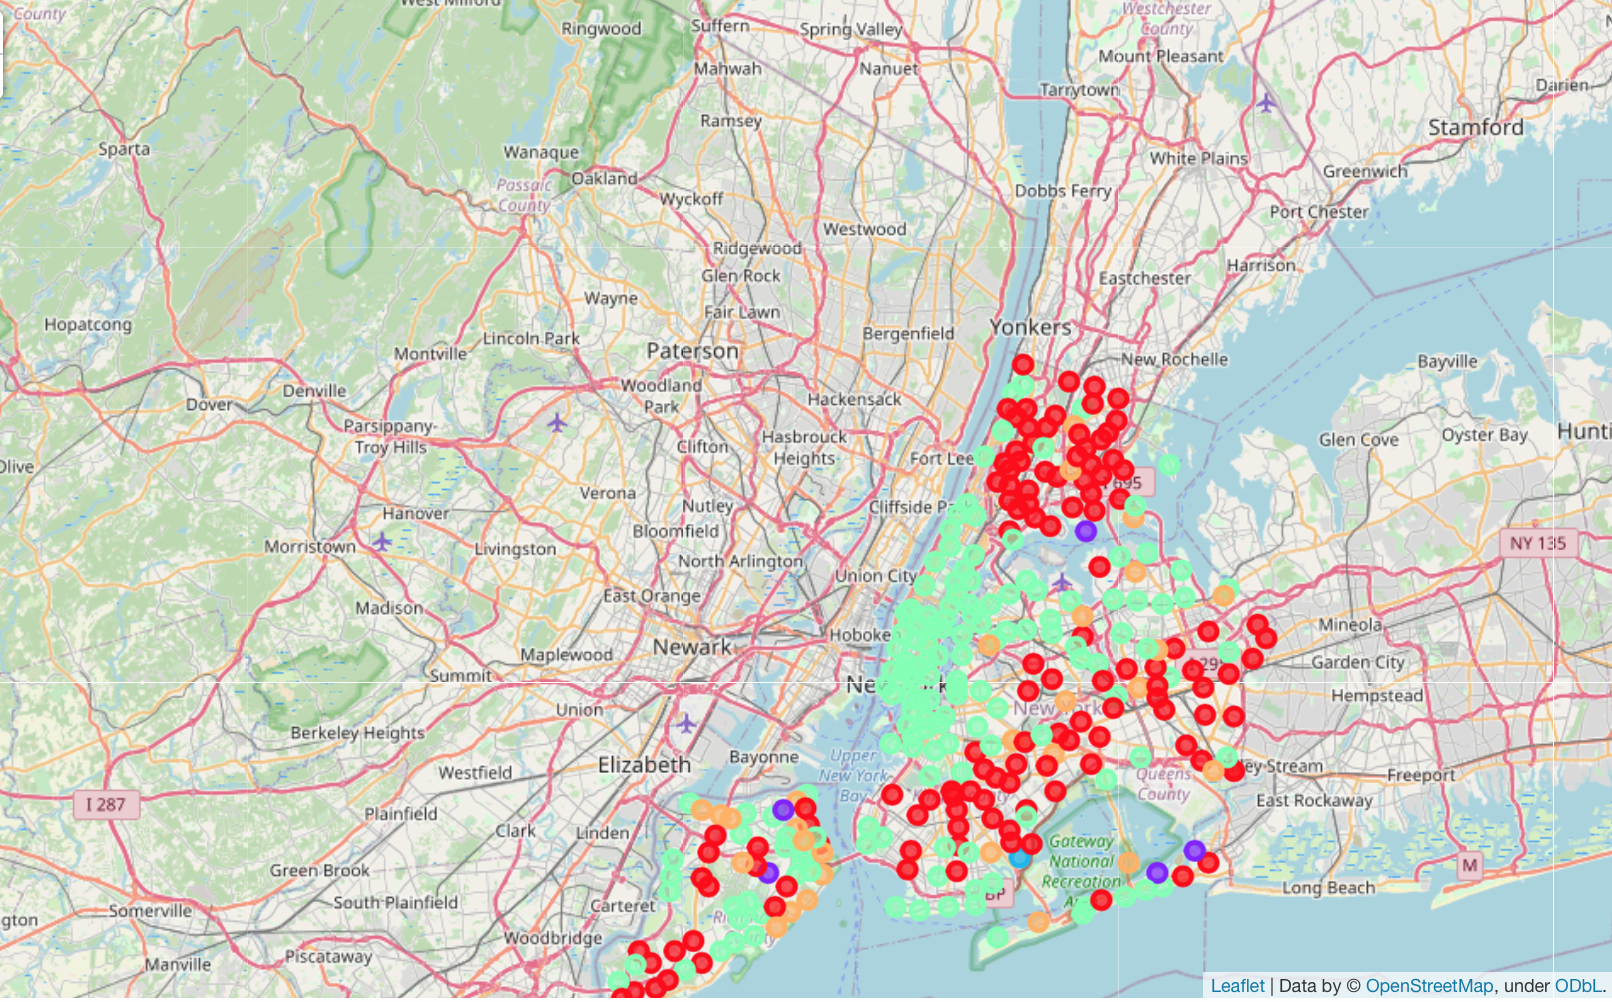

In [7]:
# Taking screenshot from output above as Git cann't display folium output properly
from IPython.display import Image
Image(filename='~/Screenshot_Output24.png') 

In [25]:
# create map for NY
from geopy.geocoders import Nominatim
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(data_merged['Latitude'], data_merged['Longitude'], data_merged['Neighborhood'], data_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[np.int(cluster-1)],
        fill=True,
        fill_color=rainbow[np.int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


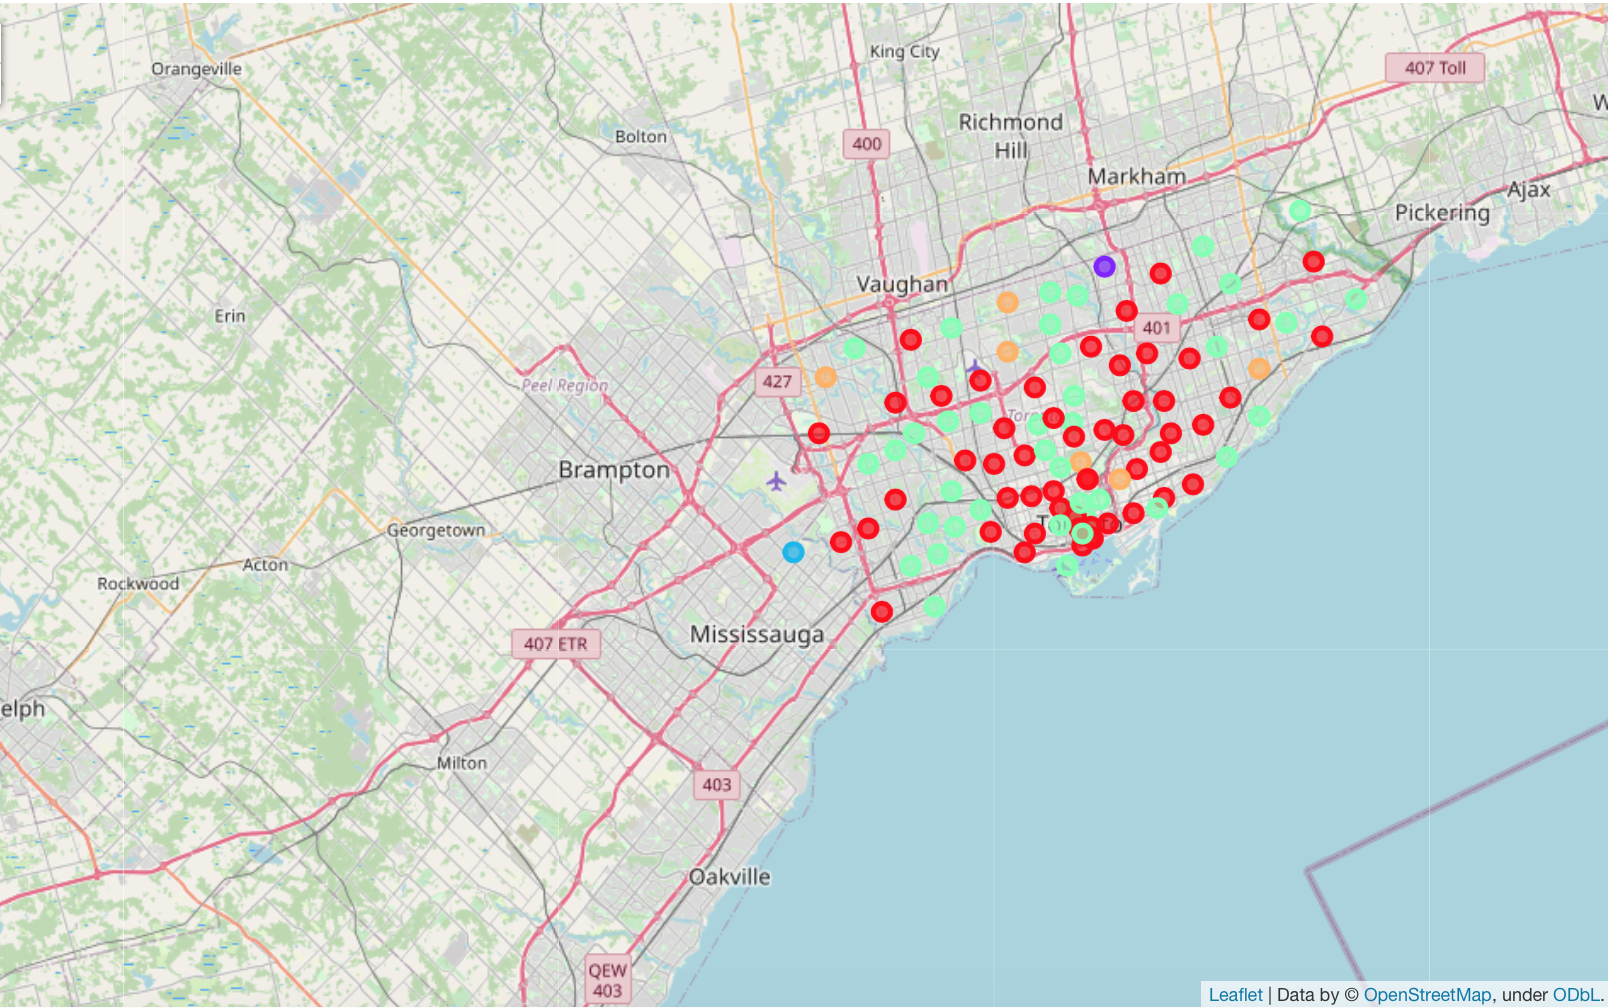

In [6]:
# Taking screenshot from output above as Git cann't display folium output properly
from IPython.display import Image
Image(filename='~/Screenshot_Output25.png') 

# Cluster Analysis

In [26]:
for cluster_labels in range (kclusters):
    print("Cluster", cluster_labels, "has:",
        data_merged.loc[data_merged['Cluster Labels'] == cluster_labels, \
                        data_merged.columns[[1] + list(range(4, data_merged.shape[1]))]].shape[0], "out of", data_merged.shape[0])

Cluster 0 has: 177 out of 409
Cluster 1 has: 6 out of 409
Cluster 2 has: 2 out of 409
Cluster 3 has: 190 out of 409
Cluster 4 has: 34 out of 409


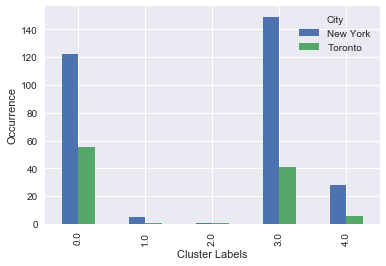

In [27]:
clusterData=data_merged#.loc[data_merged['Cluster Labels'] == 0, data_merged.columns[[1] + list(range(4, data_merged.shape[1]))]]
ax = clusterData.groupby(['Cluster Labels','City']).size().unstack().plot(kind='bar',stacked=False)
ax.set_ylabel('Occurrence')

## Cluster 0

In [28]:
data_merged.loc[data_merged['Cluster Labels'] == 0, data_merged.columns[[1] + list(range(4, data_merged.shape[1]))]]

Neighborhood      City  \
0                                           Wakefield  New York   
1                                          Co-op City  New York   
2                                         Eastchester  New York   
5                                         Kingsbridge  New York   
6                                         Marble Hill  New York   
7                                            Woodlawn  New York   
8                                             Norwood  New York   
10                                         Baychester  New York   
11                                     Pelham Parkway  New York   
13                                       Bedford Park  New York   
14                                 University Heights  New York   
15                                     Morris Heights  New York   
16                                            Fordham  New York   
17                                       East Tremont  New York   
18                                         West Farms  New York   
19                                       High  Bridge  New York   
20                                            Melrose  New York   
21                                         Mott Haven  New York   
23                                           Longwood  New York   
24                                        Hunts Point  New York   
25                                         Morrisania  New York   
26                                          Soundview  New York   
29                                       Country Club  New York   
30                                        Parkchester  New York   
31                                 Westchester Square  New York   
33                                        Morris Park  New York   
35                                     Spuyten Duyvil  New York   
36                                    North Riverdale  New York   
37                                         Pelham Bay  New York   
38                                      Schuylerville  New York   
..                                                ...       ...   
33                       Fairview, Henry Farm, Oriole   Toronto   
35                                       East Toronto   Toronto   
36  Harbourfront East, Toronto Islands, Union Station   Toronto   
37                           Little Portugal, Trinity   Toronto   
38        East Birchmount Park, Ionview, Kennedy Park   Toronto   
40                        CFB Toronto, Downsview East   Toronto   
42           Design Exchange, Toronto Dominion Centre   Toronto   
43       Brockton, Exhibition Place, Parkdale Village   Toronto   
44                    Clairlea, Golden Mile, Oakridge   Toronto   
45                           Silver Hills, York Mills   Toronto   
47                     The Beaches West, India Bazaar   Toronto   
48                     Commerce Court, Victoria Hotel   Toronto   
53                                  Downsview Central   Toronto   
54                                    Studio District   Toronto   
55                  Bedford Park, Lawrence Manor East   Toronto   
56      Del Ray, Keelsdale, Mount Dennis, Silverthorn   Toronto   
57                                   Emery, Humberlea   Toronto   
60                                Downsview Northwest   Toronto   
71                                  Maryvale, Wexford   Toronto   
73                                 North Toronto West   Toronto   
74                The Annex, North Midtown, Yorkville   Toronto   
75                             Parkdale, Roncesvalles   Toronto   
79                                         Davisville   Toronto   
80                     Harbord, University of Toronto   Toronto   
90                      L'Amoreaux West, Steeles West   Toronto   
91                                           Rosedale   Toronto   
91                                           Rosedale   Toronto   
92                    Stn A PO Boxes 25 The Esplanade   Toronto   
93                   

## Cluster 1

In [29]:
data_merged.loc[data_merged['Cluster Labels'] == 1, data_merged.columns[[1] + list(range(4, data_merged.shape[1]))]]

Neighborhood      City  Cluster Labels 1st Most Common Venue  \
27        Clason Point  New York             1.0                  Park   
192         Somerville  New York             1.0                  Park   
203          Todt Hill  New York             1.0                  Park   
256      Randall Manor  New York             1.0                  Park   
303          Bayswater  New York             1.0            Playground   
27   Hillcrest Village   Toronto             1.0                  Park   

    2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
27          Grocery Store                  Pool          Boat or Ferry   
192         Women's Store    English Restaurant   Ethiopian Restaurant   
203         Women's Store    English Restaurant   Ethiopian Restaurant   
256              Bus Stop            Bagel Shop                  Field   
303                  Park  Fast Food Restaurant  Entertainment Service   
27          Boat or Ferry         Grocery Store                   Pool   

    5th Most Common Venue      6th Most Common Venue 7th Most Common Venue  \
27               Bus Stop  South American Restaurant  Fast Food Restaurant   
192         Event Service                Event Space               Exhibit   
203         Event Service                Event Space               Exhibit   
256  Ethiopian Restaurant              Event Service           Event Space   
303  Ethiopian Restaurant              Event Service           Event Space   
27               Bus Stop  South American Restaurant         Women's Store   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
27   Ethiopian Restaurant         Event Service            Event Space  
192            Eye Doctor               Factory     Falafel Restaurant  
203            Eye Doctor               Factory     Falafel Restaurant  
256               Exhibit            Eye Doctor                Factory  
303               Exhibit            Eye Doctor                Factory  
27                Factory    English Restaurant   Ethiopian Restaurant

## Cluster 2

In [30]:
data_merged.loc[data_merged['Cluster Labels'] == 2, data_merged.columns[[1] + list(range(4, data_merged.shape[1]))]]

Neighborhood      City  Cluster Labels  \
76                            Mill Island  New York             2.0   
76  Canada Post Gateway Processing Centre   Toronto             2.0   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
76                  Pool         Women's Store                 Field   
76                  Pool         Women's Store                  Farm   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
76  Entertainment Service  Ethiopian Restaurant         Event Service   
76    Empanada Restaurant    English Restaurant  Ethiopian Restaurant   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
76           Event Space               Exhibit            Eye Doctor   
76         Event Service           Event Space               Factory   

   10th Most Common Venue  
76                Factory  
76     Falafel Restaurant

## Cluster 3

In [31]:
data_merged.loc[data_merged['Cluster Labels'] == 3, data_merged.columns[[1] + list(range(4, data_merged.shape[1]))]]

Neighborhood      City  \
3                                            Fieldston  New York   
4                                            Riverdale  New York   
9                                       Williamsbridge  New York   
12                                         City Island  New York   
22                                         Port Morris  New York   
34                                             Belmont  New York   
39                                      Edgewater Park  New York   
46                                           Bay Ridge  New York   
49                                          Greenpoint  New York   
50                                           Gravesend  New York   
51                                      Brighton Beach  New York   
52                                      Sheepshead Bay  New York   
58                                     Windsor Terrace  New York   
59                                    Prospect Heights  New York   
61                                        Williamsburg  New York   
62                                            Bushwick  New York   
63                                  Bedford Stuyvesant  New York   
64                                    Brooklyn Heights  New York   
65                                         Cobble Hill  New York   
66                                     Carroll Gardens  New York   
67                                            Red Hook  New York   
68                                             Gowanus  New York   
69                                         Fort Greene  New York   
70                                          Park Slope  New York   
77                                     Manhattan Beach  New York   
78                                        Coney Island  New York   
81                                       Dyker Heights  New York   
82                                     Gerritsen Beach  New York   
84                                        Clinton Hill  New York   
85                                            Sea Gate  New York   
..                                                 ...       ...   
52                             Newtonbrook, Willowdale   Toronto   
58                         Birch Cliff, Cliffside West   Toronto   
59                                    Willowdale South   Toronto   
61                                       Lawrence Park   Toronto   
62                                            Roselawn   Toronto   
63                       The Junction North, Runnymede   Toronto   
64                                              Weston   Toronto   
65   Dorset Park, Scarborough Town Centre, Wexford ...   Toronto   
66                                     York Mills West   Toronto   
67                                    Davisville North   Toronto   
68                 Forest Hill North, Forest Hill West   Toronto   
69                       High Park, The Junction South   Toronto   
70                                           Westmount   Toronto   
77   Kingsview Village, Martin Grove Gardens, Richv...   Toronto   
78                                           Agincourt   Toronto   
81                                  Runnymede, Swansea   Toronto   
82             Clarks Corners, Sullivan, Tam O'Shanter   Toronto   
84           Chinatown, Grange Park, Kensington Market   Toronto   
85   Agincourt North, L'Amoreaux East, Milliken, St...   Toronto   
86   Deer Park, Forest Hill SE, Rathnelly, South Hi...   Toronto   
87   CN Tower, Bathurst Quay, Island airport, Harbo...   Toronto   
88        Humber Bay Shores, Mimico South, New Toronto   Toronto   
95                                         Upper Rouge   Toronto   
96                         Cabbagetown, St. James Town   Toronto   
97              First Canadian Place, Underground city   Toronto   
98       The Kingsway, Montgomery Road, Old Mill North   Toronto   
99                                Church and Wellesley   Toronto   
100   Business reply mail Proc

# Cluster 4

In [32]:
data_merged.loc[data_merged['Cluster Labels'] == 4, data_merged.columns[[1] + list(range(4, data_merged.shape[1]))]]

Neighborhood      City  \
28                                         Throgs Neck  New York   
32                                            Van Nest  New York   
41                                           Olinville  New York   
72                                       East New York  New York   
83                                         Marine Park  New York   
89                                          Ocean Hill  New York   
144                                           Glendale  New York   
150                                         Whitestone  New York   
154                                         Douglaston  New York   
159                                          Briarwood  New York   
171                                      Broad Channel  New York   
193                                         Brookville  New York   
195                                       North Corona  New York   
198                                       New Brighton  New York   
202                                        Grymes Hill  New York   
204                                        South Beach  New York   
206                                   Mariner's Harbor  New York   
227                                          Arlington  New York   
228                                           Arrochar  New York   
232                                      Midland Beach  New York   
234                                     New Dorp Beach  New York   
252                                        Shore Acres  New York   
258                                           Elm Park  New York   
264                                             Utopia  New York   
278                                         Blissville  New York   
285                                        Willowbrook  New York   
288                                            Roxbury  New York   
305                                          Fox Hills  New York   
28     Bathurst Manor, Downsview North, Wilson Heights   Toronto   
32                                 Scarborough Village   Toronto   
41                        The Danforth West, Riverdale   Toronto   
72                                     Willowdale West   Toronto   
83                         Moore Park, Summerhill East   Toronto   
89   Albion Gardens, Beaumond Heights, Humbergate, ...   Toronto   

     Cluster Labels 1st Most Common Venue            2nd Most Common Venue  \
28              4.0         Deli / Bodega               Italian Restaurant   
32              4.0           Pizza Place                    Deli / Bodega   
41              4.0    Chinese Restaurant                    Deli / Bodega   
72              4.0         Event Service                    Deli / Bodega   
83              4.0    Chinese Restaurant                              Gym   
89              4.0         Deli / Bodega  Southern / Soul Food Restaurant   
144             4.0    Chinese Restaurant                    Deli / Bodega   
150             4.0          Dance Studio                  Bubble Tea Shop   
154             4.0         Deli / Bodega                             Bank   
159             4.0         Deli / Bodega              Arts & Crafts Store   
171             4.0           Pizza Place                         Dive Bar   
193             4.0         Deli / Bodega                    Women's Store   
195             4.0         Deli / Bodega             Gym / Fitness Center   
198             4.0              Bus Stop                             Park   
202             4.0               Dog Run                         Bus Stop   
204             4.0                 Beach                             Pier   
206             4.0    Italian Restaurant                    Deli / Bodega   
227             4.0              Bus Stop                    Deli / Bodega   
228             4.0              Bus Stop               Italian Restaurant   
232             4.0                 Beach                    Deli / Bodega   
234             4.0    